# This notebook contains Vignette Removal & Size Re-Scaling


## Part 1: Vignette Removal

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os 
import math 
from PIL import Image
import cv2 



In [ ]:
input_dir = '../datasets/ISIC_2019_cleaned/'
input_metadata_file = 'resampled_metadata.csv'

metadata_df = pd.read_csv(input_dir + input_metadata_file)

In [ ]:
# For each image in metadata_df, we will read the image and determine the size of the image
def get_image_size(image_path):
    try:
        img = Image.open(image_path)
        width, height = img.size
        return width, height
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None, None
    

# Create a new DataFrame to store the image sizes, merge with original metadata
image_sizes = []
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    image_path = os.path.join(input_dir, row['image'])
    width, height = get_image_size(image_path)
    if width is not None and height is not None:
        image_sizes.append({'image': row['image'], 'width': width, 'height': height})
    else:
        image_sizes.append({'image': row['image'], 'width': None, 'height': None})
image_sizes_df = pd.DataFrame(image_sizes)

metadata_df = pd.merge(metadata_df, image_sizes_df, on='image', how='left')

100%|██████████| 8000/8000 [00:01<00:00, 4572.39it/s]


In [16]:
def detect_circular_vignette(image_path, display=False, brightness_threshold=0.95):
    """
    Detect and mask circular vignettes based on radial brightness profile, and
    crops the image to the square incvribed in the circle of the vignette.

    Returns:
        The cropped image, and its dimensions.
    """
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # color correction for the gray image
    # gray = cv2.equalizeHist(gray)

    # Determine hight, width, and center
    h, w = gray.shape
    center = (w // 2, h // 2)

    # Compute distance from the center for each pixel
    Y, X = np.indices((h, w))
    distance = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    # Build radial brightness profile
    max_distance = np.max(distance)
    num_bins = 100
    radial_means = np.zeros(num_bins)
    bin_edges = np.linspace(0, max_distance, num_bins + 1)

    for i in range(num_bins):
        mask = (distance >= bin_edges[i]) & (distance < bin_edges[i+1])
        if np.any(mask):
            radial_means[i] = np.mean(gray[mask])

    # Normalize radial profile
    # radial_means /= np.max(radial_means)

    # Detect the radius where brightness drops below the threshold
    valid_bins = np.where(radial_means > brightness_threshold)[0]
    if len(valid_bins) == 100:
        img2, h2, w2 =  img, w, h
    elif len(valid_bins) == 0:
        img2, h2, w2 =  img, w, h
    elif valid_bins[-1] == 99:
        img2, h2, w2 =  img, w, h
    else:
        valid_radius = bin_edges[valid_bins[-1]]
        h2, w2 = round(valid_radius * np.sqrt(2)), round(valid_radius * np.sqrt(2))
        img2 = cv2.getRectSubPix(img, (w2, h2), center)


    if display:
        fig, ax = plt.subplots(1,3,figsize=(20, 5))

        ax[0].imshow(img); ax[0].set_title(f"Original Image w:{img.shape}"); ax[0].axis('off')
        ax[1].plot(radial_means); ax[1].set_title('Radial Brightness Profile')
        ax[1].axhline(y=brightness_threshold, color='r', linestyle='--')
        ax[2].imshow(img2);  ax[2].set_title(f'Square w:{img2.shape}'); ax[2].axis('off')

        plt.show()

    return img2, w2, h2

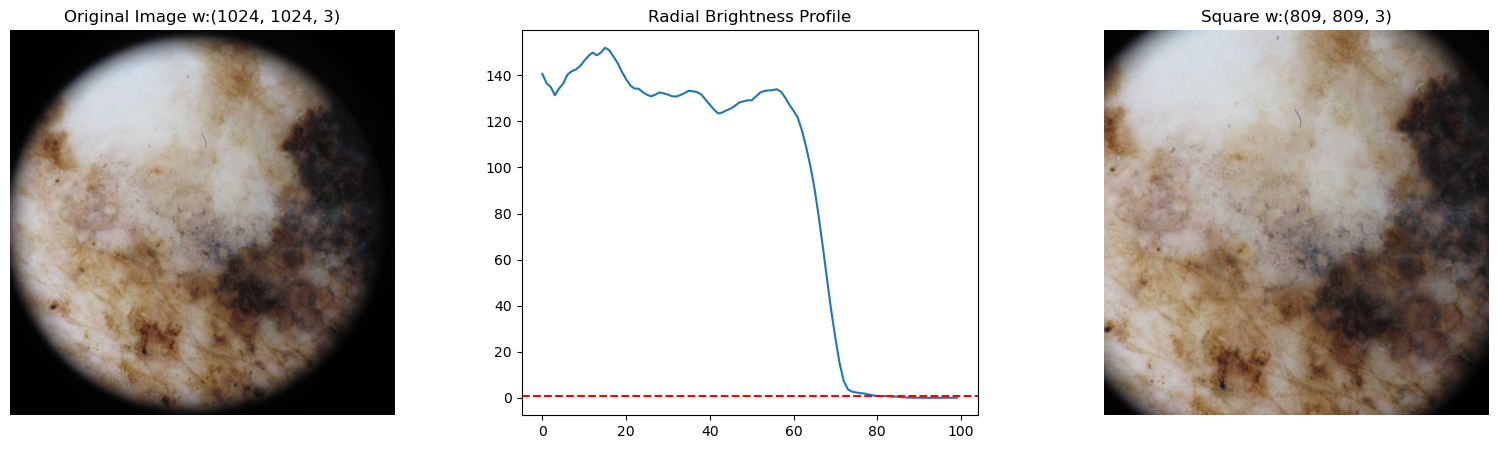

In [17]:
img_array, h , w = detect_circular_vignette(input_dir + metadata_df.loc[10,"image"], brightness_threshold=.8, display = True)


In [22]:
metadata_new = metadata_df.copy()
folder_target = '../datasets/ISIC_2019_cleaned_cropped/'
# Crop and Add the new dimensions to the metadata file (this process takes 2 hrs)
for idx in tqdm(metadata_df.index, desc="Processing Files"):
    cropped_img, h , w = detect_circular_vignette(input_dir + metadata_df.loc[idx,"image"], brightness_threshold=100)
    cropped_img = Image.fromarray(cropped_img)
    metadata_new.loc[idx, 'cropped_width'] = w
    metadata_new.loc[idx, 'cropped_height'] = h
    cropped_img.save(folder_target + metadata_df.loc[idx, 'image'])
metadata_new.to_csv(folder_target + 'resampled_metadata_cropped.csv', index=False)

Processing Files: 100%|██████████| 8000/8000 [08:05<00:00, 16.47it/s]


## Part 2: Resizing

<Axes: >

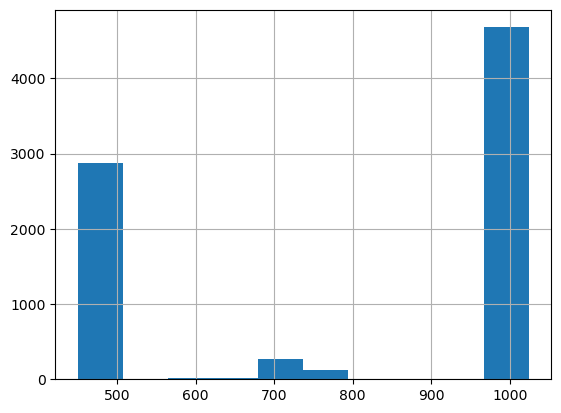

In [23]:
metadata_new['width'].hist()

In [28]:
metadata_new['width'].sort_values()

3999     450
6401     450
6400     450
6399     450
2826     450
        ... 
3394    1024
3393    1024
3392    1024
3401    1024
7999    1024
Name: width, Length: 8000, dtype: int64

In [33]:

def resize_images(metadata_df, folder_source, folder_target, target_size):
    df = metadata_df[metadata_df['width'] >= target_size[0]]
    for idx in tqdm(df.index,desc="Processing Files"):
        img_path = folder_source + df.loc[idx, 'image']
        img = np.array(Image.open(img_path))
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA) # the inter_area method includes the gaussian effect
        resized_img = Image.fromarray(resized_img)
        resized_img.save(folder_target + df.loc[idx, 'image'])
    metadata_df[['width', 'height']] = target_size
    return metadata_df

folder_source = '../datasets/ISIC_2019_cleaned_cropped/'
folder_target = '../datasets/ISIC_2019_cleaned_cropped_resized/'
resize_images(metadata_df, folder_source, folder_target, (450, 450))

metadata_df.to_csv(folder_target + 'resampled_metadata_resized.csv', index=False)


Processing Files: 100%|██████████| 8000/8000 [01:14<00:00, 107.77it/s]


In [34]:
metadata_df

,image,category,augmentation_method,width,height
0,ISIC_0068778_preprocessed_rot0.jpg,MEL,rot0,450,450
1,ISIC_0058285_preprocessed_rot0.jpg,MEL,rot0,450,450
2,ISIC_0073194_preprocessed_rot0.jpg,MEL,rot0,450,450
3,ISIC_0058003_preprocessed_rot0.jpg,MEL,rot0,450,450
4,ISIC_0070105_preprocessed_rot0.jpg,MEL,rot0,450,450
...,...,...,...,...,...
7995,ISIC_0026645_preprocessed_rot90.jpg,SCC,rot90,450,450
7996,ISIC_0029417_preprocessed_rot90.jpg,SCC,rot90,450,450
7997,ISIC_0071393_preprocessed_rot90.jpg,SCC,rot90,450,450
7998,ISIC_0068266_preprocessed_rot90.jpg,SCC,rot90,450,450
